In [1]:
"""
 @utor : Alexandre Lainé 
 Δate : 2024-03-16 
"""

'\n @utor : Alexandre Lainé \n Δate : 2024-03-16 \n'

# **Predicting the survival of the Titanic's passengers**

In [2]:
# Module importation
from sklearn.model_selection import train_test_split
import sklearn.utils as sk_utilis
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import optuna
import torch
import os

## 1. Data importation and preparation

In [3]:
cwd = os.getcwd()

In [4]:
# select dataset path
data_folder = "datasets"
data_path = os.path.join(cwd, data_folder, "titanic.csv")

# verification
if os.path.exists(data_path):
    print("All is good, we can go on !")
else:
    raise FileExistsError("The path doesn't exist !")

All is good, we can go on !


In [5]:
# load the dataset
data = pd.read_csv(data_path, sep=";")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [6]:
# select just few columns
data_ = data[["pclass", "survived", "sex", "age", "sibsp", "parch"]]

# drop rows with NA value and quantify the gender (?!)
Data  = data_.dropna(axis=0).replace(to_replace=["male","female"], value=[0,1])
Data.describe()

,pclass,survived,sex,age,sibsp,parch
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.00000
mean,2.207457,0.408222,0.370937,29.881135,0.502868,0.42065
std,0.841497,0.491740,0.483287,14.413500,0.912167,0.83975
min,1.000000,0.000000,0.000000,0.166700,0.000000,0.00000
25%,1.000000,0.000000,0.000000,21.000000,0.000000,0.00000
50%,2.000000,0.000000,0.000000,28.000000,0.000000,0.00000
75%,3.000000,1.000000,1.000000,39.000000,1.000000,1.00000
max,3.000000,1.000000,1.000000,80.000000,8.000000,6.00000


In [7]:
# normalisation of each column
DATA = Data/Data.max()
DATA.describe()

,pclass,survived,sex,age,sibsp,parch
count,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000,1046.000000
mean,0.735819,0.408222,0.370937,0.373514,0.062859,0.070108
std,0.280499,0.491740,0.483287,0.180169,0.114021,0.139958
min,0.333333,0.000000,0.000000,0.002084,0.000000,0.000000
25%,0.333333,0.000000,0.000000,0.262500,0.000000,0.000000
50%,0.666667,0.000000,0.000000,0.350000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.487500,0.125000,0.166667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
# split the dataset
X, Y = DATA[["pclass","sex","age","sibsp","parch"]], DATA["survived"]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

## 2. Model preparation

In [9]:
# model creation
class my_classifier(torch.nn.Module):
    def __init__(self, c, N):
        super(my_classifier, self).__init__()
         
        self.linear_input = torch.nn.Linear(c, N) # not necessary
        self.linear_output = torch.nn.Linear(N, 1)
        self.sigmoid = torch.nn.Sigmoid() # replace the output between 0 and 1 for the BCE

    def forward(self, x):
        
        x_in = self.linear_input(x)
        x = self.linear_output(x_in) 
        x_out = self.sigmoid(x)

        return x_out

In [10]:
# select the loss function for the binary classification
criterion = torch.nn.BCELoss(reduction="mean") 

In [11]:
# select the device support
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [12]:
# training fonction for the model
def train_model(
        num_epochs=1_000,
        criterion=criterion,
        lr=0.01,
        
        c=5,
        N=5,
        X_train=X_train,
        Y_train=Y_train,
        X_test=X_test,
        Y_test=Y_test,
        device=device,

        disable_tqdm=False
):
    
    # Initialisation
    model = my_classifier(c=c, N=N).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    X_train = torch.Tensor(X_train.to_numpy()).to(device)
    Y_train = torch.Tensor(Y_train.to_numpy()).to(device)

    # result vector
    results_loss = torch.zeros((num_epochs))
    results_accuracy = torch.zeros((num_epochs))

    for epoch in tqdm(range(num_epochs), disable=disable_tqdm):
        
        model.train()
        output = model(X_train)[:,0]
        
        loss = criterion(output, Y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        results_loss[epoch] = loss.item()

        with torch.no_grad() :

            Y_pred = model(torch.Tensor(X_test.to_numpy()).to(device))[:,0]
            
            results_accuracy[epoch] = (Y_pred.round().cpu().detach().numpy() == Y_test.to_numpy()).sum()/len(Y_test.to_numpy()) * 100
    
    return results_loss, results_accuracy, model

## 3. Model training

In [13]:
# used data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# training parameters
num_epochs=100
N = 5

# first training
loss, accuracy, model = train_model(
                                N=N,
                                X_train=X_train,
                                Y_train=Y_train,
                                X_test=X_test,
                                Y_test=Y_test,
                                num_epochs=num_epochs,
                                disable_tqdm=False
                                )

100%|██████████| 100/100 [00:00<00:00, 222.27it/s]


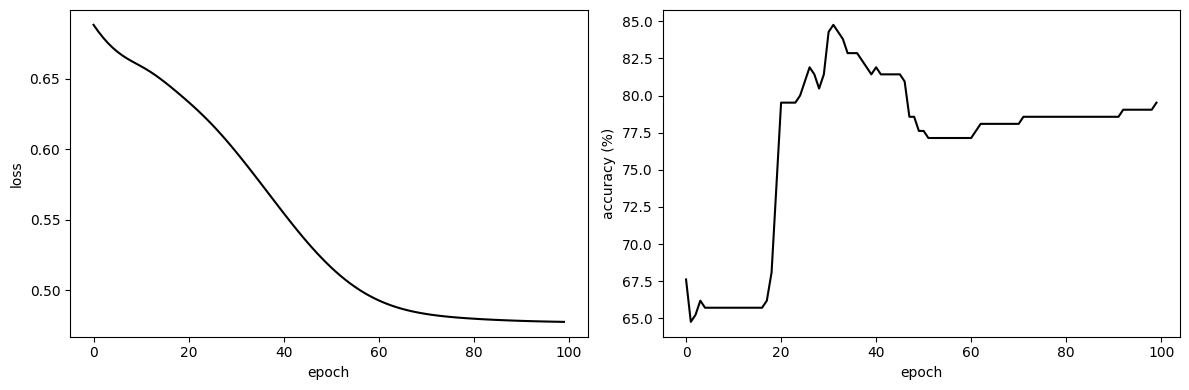

In [14]:
# result presentation
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharex=True)

# loss function
ax[0].plot(range(num_epochs), loss, color="black")
ax[0].set_ylabel("loss")
ax[0].set_xlabel("epoch")

# accuracy plot
ax[1].plot(range(num_epochs), accuracy, color="black")
ax[1].set_ylabel("accuracy (%)")
ax[1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [15]:
# repet training parameters
repet = 50
num_epochs = 50
N = 5

# results vectors
Loss = torch.zeros((repet, num_epochs))
Accuracy = torch.zeros((repet, num_epochs))
shuff_Loss = torch.zeros((repet, num_epochs))
shuff_Accuracy = torch.zeros((repet, num_epochs))

random_chain = torch.randint(low=0, high=100, size=(repet,))

# repetition of the training
for i in tqdm(range(repet)):

    # used data
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)
    shuff_Y_test = sk_utilis.shuffle(Y_test)

    # training
    Loss[i,:], Accuracy[i,:], model = train_model(
                                    N=N,
                                    c=X_train.shape[-1],
                                    X_train=X_train,
                                    Y_train=Y_train,
                                    X_test=X_test,
                                    Y_test=Y_test,
                                    num_epochs=num_epochs,
                                    disable_tqdm=True
                                    )
    
    # trainig on shuffle data
    shuff_Loss[i,:], shuff_Accuracy[i,:], model = train_model(
                                    N=N,
                                    c=X_train.shape[-1],
                                    X_train=X_train,
                                    Y_train=Y_train,
                                    X_test=X_test,
                                    Y_test=shuff_Y_test,
                                    num_epochs=num_epochs,
                                    disable_tqdm=True
                                    )

100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


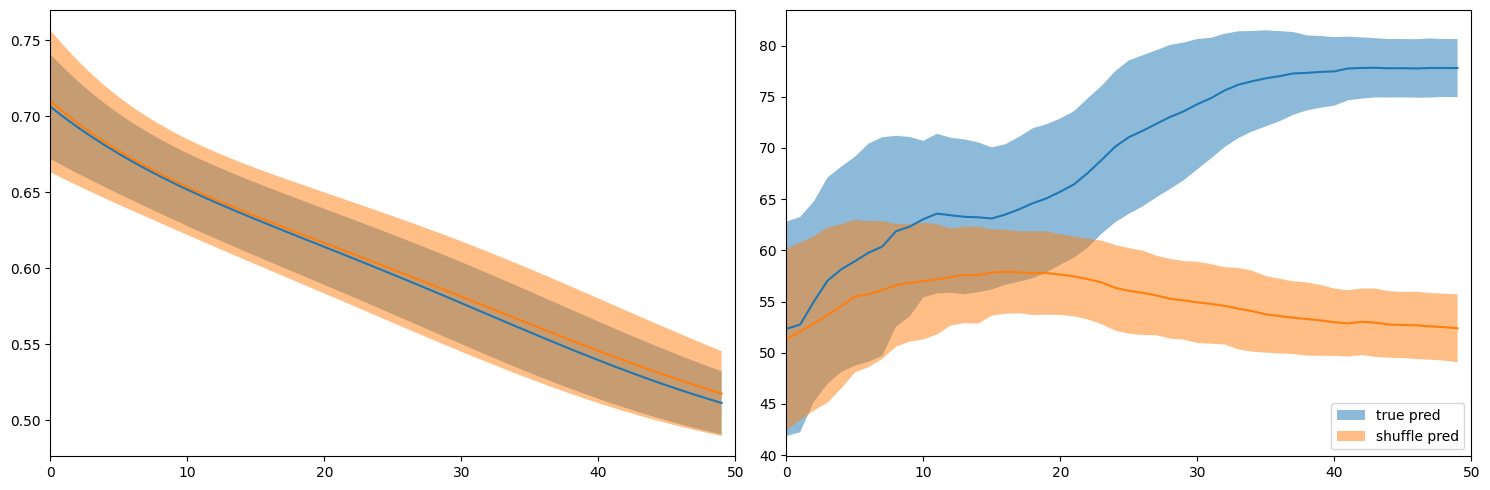

In [16]:
colors = ["true pred","shuffle pred"]

# results presentation
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharex=True)

# loss functions
for X0 in [Loss, shuff_Loss]:
    ax[0].fill_between(range(num_epochs),
                           X0.mean(axis=0) - X0.std(axis=0),
                           X0.mean(axis=0) + X0.std(axis=0),
                           alpha=0.5)
    ax[0].plot(range(num_epochs), X0.mean(axis=0))

# accuracy plot
for i,X1 in enumerate([Accuracy, shuff_Accuracy]):
    ax[1].fill_between(range(num_epochs),
                           X1.mean(axis=0) - X1.std(axis=0),
                           X1.mean(axis=0) + X1.std(axis=0),
                           label=f"{colors[i]}", alpha=0.5)
    ax[1].plot(range(num_epochs), X1.mean(axis=0))

ax[1].set_xlim(0, num_epochs)
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## 4. Model optimisation

In [17]:
# try the optuna optimization
def objective(trial):
    
    N_neuron = trial.suggest_int('N', 2, 1000)

    cv = 10
    num_epochs = 10
    
    random_chain = torch.randint(low=0, high=100, size=(cv,))
    
    Loss = torch.zeros((cv, num_epochs))
    Accuracy = torch.zeros((cv, num_epochs))

    for i,rdn in enumerate(random_chain) :

        X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=rdn.item())
        
        Loss[i,:], Accuracy[i,:], model = train_model(
                                        N=N_neuron,
                                        X_train=X_train,
                                        Y_train=Y_train,
                                        X_test=X_test,
                                        Y_test=Y_test,
                                        num_epochs=num_epochs,
                                        disable_tqdm=True
                                        )
    
    return Accuracy.mean(axis=0)[-1].item()

study = optuna.create_study(direction="maximize", study_name="2024-03-19_N-optimisation")
study.optimize(objective, n_trials=1000, n_jobs=-1)

study.best_params

[I 2024-03-19 23:56:22,461] A new study created in memory with name: 2024-03-19_N-optimisation
[I 2024-03-19 23:56:23,771] Trial 1 finished with value: 79.19047546386719 and parameters: {'N': 440}. Best is trial 1 with value: 79.19047546386719.
[I 2024-03-19 23:56:23,829] Trial 0 finished with value: 78.38095092773438 and parameters: {'N': 510}. Best is trial 1 with value: 79.19047546386719.
[I 2024-03-19 23:56:24,150] Trial 6 finished with value: 74.80952453613281 and parameters: {'N': 34}. Best is trial 1 with value: 79.19047546386719.
[I 2024-03-19 23:56:24,284] Trial 10 finished with value: 78.85714721679688 and parameters: {'N': 922}. Best is trial 1 with value: 79.19047546386719.
[I 2024-03-19 23:56:24,364] Trial 8 finished with value: 78.3809585571289 and parameters: {'N': 813}. Best is trial 1 with value: 79.19047546386719.
[I 2024-03-19 23:56:24,435] Trial 15 finished with value: 80.00000762939453 and parameters: {'N': 52}. Best is trial 15 with value: 80.00000762939453.
[I 20

{'N': 151}

## 5. Extract model parameters

In [18]:
# training parameters
num_epochs = 100
N = 5

# used data
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

# model training
loss, accuracy, model = train_model(
                                N=N,
                                c=X_train.shape[-1],
                                X_train=X_train,
                                Y_train=Y_train,
                                X_test=X_test,
                                Y_test=Y_test,
                                num_epochs=num_epochs,
                                disable_tqdm=False
                                )


100%|██████████| 100/100 [00:00<00:00, 420.92it/s]


In [19]:
# extract layer weights
input_layer = model.linear_input.weight.cpu().detach().numpy()
output_layer = model.linear_output.weight.cpu().detach().numpy()

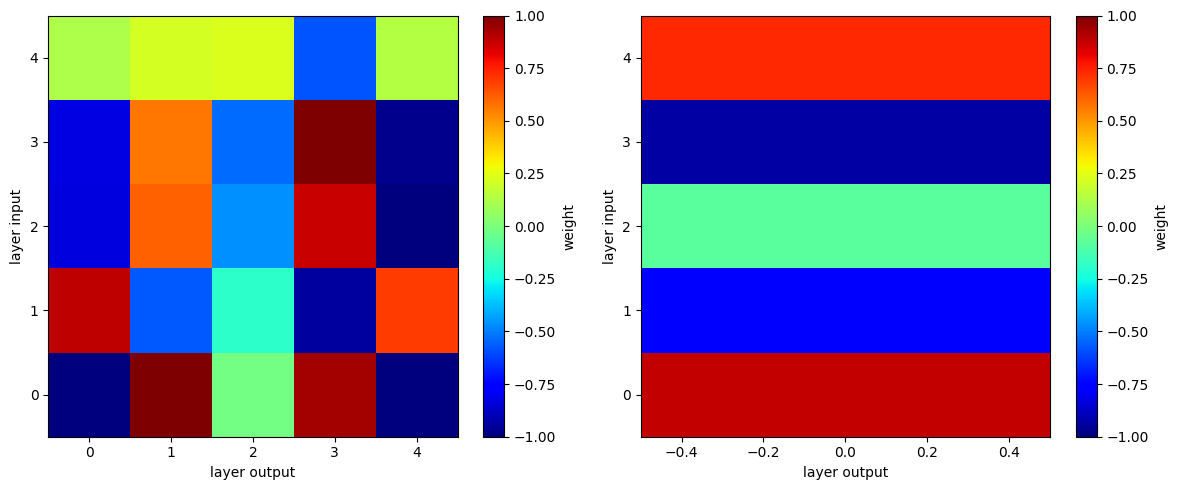

In [20]:
# weights représentation
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

# first layer : input_layer
g0 = ax[0].imshow(input_layer.T, cmap="jet",
                  aspect="auto", origin="lower",
                  vmin=-1, vmax=1)
c0 = fig.colorbar(g0, ax=ax[0])
c0.set_label("weight")
ax[0].set_ylabel("layer input")
ax[0].set_xlabel("layer output")

# second layer : output_layer
g1 = ax[1].imshow(output_layer.T, cmap="jet",
                  aspect="auto", origin="lower",
                  vmin=-1, vmax=1)
c1 = fig.colorbar(g1, ax=ax[1])
c1.set_label("weight")
ax[1].set_ylabel("layer input")
ax[1].set_xlabel("layer output")

plt.tight_layout()
plt.show()